# Set up

In [1]:
import pandas as pd
import numpy as np
import json
import pickle
import os

METADATA_FILEPATH = '../dataset/metadata.json'

Sources: 

https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456

# Load training set

In [2]:
with open(METADATA_FILEPATH, 'r') as f:
    metadata = json.load(f)

In [3]:
df = pd.DataFrame(metadata)

In [4]:
df.head(10)

,claim,claimant,date,label,related_articles,id
0,A line from George Orwell's novel 1984 predict...,,2017-07-17,0,"[122094, 122580, 130685, 134765]",0
1,Maine legislature candidate Leslie Gibson insu...,,2018-03-17,2,"[106868, 127320, 128060]",1
2,A 17-year-old girl named Alyssa Carson is bein...,,2018-07-18,1,"[132130, 132132, 149722]",4
3,In 1988 author Roald Dahl penned an open lette...,,2019-02-04,2,"[123254, 123418, 127464]",5
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,2,"[41099, 89899, 72543, 82644, 95344, 88361]",6
5,"Rhode Island is ""almost dead last"" among North...",Leonidas Raptakis,2014-02-11,2,"[8284, 3768, 20091, 82368, 73148, 4493]",7
6,The poorest counties in the U.S. are in Appala...,Jim Webb,2014-11-19,1,"[70709, 70708]",8
7,Koch Industries paid the legal fees of George ...,,2013-07-18,0,"[120591, 120592, 127866, 129483]",9
8,"""Minnesota, Michigan, Iowa already have 70 mph...",Robin Vos,2013-08-22,1,"[69547, 80095, 7994, 81116, 77621]",11
9,"""FBI Uniform Crime Report for 2016 shows more ...",Nick Schroer,2017-10-17,1,"[72012, 26005, 43481, 55671]",12


In [5]:
len(df)

15555

# Preparing the text data

In [6]:
import string
import gensim
from nltk.tokenize import word_tokenize

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 1000

In [7]:
claims = list()
lines = df['claim'].values.tolist()

In [8]:
for line in lines:
    tokens = word_tokenize(line)
    # convert to lowercase
    tokens = [w.lower() for w in tokens]
    # remove punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    claims.append(words)

In [9]:
len(claims)

15555

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(claims)
sequences = tokenizer.texts_to_sequences(claims)

In [12]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 21392 unique tokens.


In [13]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [14]:
labels = df['label'].values
labels = to_categorical(np.asarray(labels))

In [15]:
print("Shape of data tensor:", data.shape)

Shape of data tensor: (15555, 1000)


In [16]:
print("Shape of label tensor:", labels.shape)

Shape of label tensor: (15555, 3)


In [17]:
# split the data into a training set and a validation set
VALIDATION_SPLIT = 0.2

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

In [18]:
X_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
X_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [19]:
print("Shape of X_train tensor:", X_train.shape)
print("Shape of y_train tensor:", y_train.shape)

print("Shape of X_val tensor:", X_val.shape)
print("Shape of y_val tensor:", y_val.shape)

Shape of X_train tensor: (12444, 1000)
Shape of y_train tensor: (12444, 3)
Shape of X_val tensor: (3111, 1000)
Shape of y_val tensor: (3111, 3)


# Preparing the embedding layer

In [20]:
embeddings_index = {}
with open("../reference/glove.6B.300d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [21]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

In [22]:
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [23]:
from keras.layers.embeddings import Embedding

In [62]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Training a 1D convnet

In [50]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Flatten, LSTM, GRU
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD

In [52]:
m1 = Sequential()
m1.add(embedding_layer)
m1.add(Conv1D(128, 5, activation='relu'))
m1.add(MaxPooling1D(5))
m1.add(Dropout(0.5))
m1.add(Conv1D(128, 5, activation='relu'))
m1.add(MaxPooling1D(5))
m1.add(Dropout(0.5))
m1.add(Flatten())
m1.add(Dense(128, activation='relu'))
m1.add(Dense(3, activation='softmax'))

m1.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [60]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [ ]:
# fit model
h1 = m1.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs=10, batch_size=16, callbacks=[es])

In [54]:
from matplotlib import pyplot

# evaluate the model
_, train_acc = m1.evaluate(X_train, y_train, verbose=0)
_, test_acc = m1.evaluate(X_val, y_val, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.821, Test: 0.583


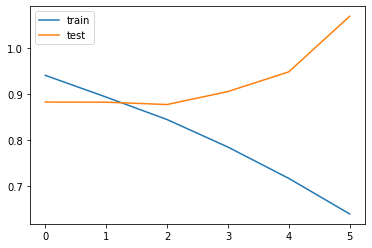

In [55]:
# plot training history
pyplot.plot(h1.history['loss'], label='train')
pyplot.plot(h1.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [57]:
m1.save("../models/conv1d_16.h5")

In [ ]:
m2 = Sequential()
m2.add(embedding_layer)
m2.add(LSTM(128))
m2.add(Dropout(0.5))
m2.add(Dense(3, activation='sigmoid'))

m2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = m2.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10)

In [ ]:
# evaluate the model
_, train_acc = m2.evaluate(X_train, y_train, verbose=0)
_, test_acc = m2.evaluate(X_val, y_val, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

In [ ]:
# plot training history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [75]:
# from keras.layers import Bidirectional

# m3 = Sequential()
# m3.add(embedding_layer)
# m3.add(Bidirectional(LSTM(64)))
# m3.add(Dropout(0.5))
# m3.add(Dense(3, activation='tanh'))

# m3.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
#               metrics=['accuracy'])

# h3 = m3.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=10, callbacks=[es])

In [71]:
from keras.optimizers import SGD

m4 = Sequential()
m4.add(embedding_layer)
m4.add(Conv1D(128, 5, activation='relu'))
m4.add(MaxPooling1D(5))
m4.add(Dropout(0.5))
m4.add(Conv1D(128, 5, activation='relu'))
m4.add(MaxPooling1D(5))
m4.add(Dropout(0.5))
m4.add(Flatten())
m4.add(Dense(128, activation='relu'))
m4.add(Dense(3, activation='softmax'))

m4.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01, nesterov=True),
              metrics=['acc'])

h4 = m4.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=20, callbacks=[es])

Train on 12444 samples, validate on 3111 samples
Epoch 1/20
12444/12444 [==============================] - 153s 12ms/step - loss: 0.9676 - acc: 0.4818 - val_loss: 0.9628 - val_acc: 0.5175
Epoch 2/20
12444/12444 [==============================] - 133s 11ms/step - loss: 0.9505 - acc: 0.5074 - val_loss: 0.9341 - val_acc: 0.5323
Epoch 3/20
12444/12444 [==============================] - 136s 11ms/step - loss: 0.9381 - acc: 0.5331 - val_loss: 0.9164 - val_acc: 0.5651
Epoch 4/20
12444/12444 [==============================] - 194s 16ms/step - loss: 0.9211 - acc: 0.5541 - val_loss: 0.9080 - val_acc: 0.5821
Epoch 5/20
12444/12444 [==============================] - 152s 12ms/step - loss: 0.9131 - acc: 0.5677 - val_loss: 0.9045 - val_acc: 0.5725
Epoch 6/20
12444/12444 [==============================] - 129s 10ms/step - loss: 0.9024 - acc: 0.5784 - val_loss: 0.8925 - val_acc: 0.5886
Epoch 7/20
12444/12444 [==============================] - 114s 9ms/step - loss: 0.8981 - acc: 0.5834 - val_loss: 0.88

In [72]:
# evaluate the model
_, train_acc = m4.evaluate(X_train, y_train, verbose=0)
_, test_acc = m4.evaluate(X_val, y_val, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.778, Test: 0.600


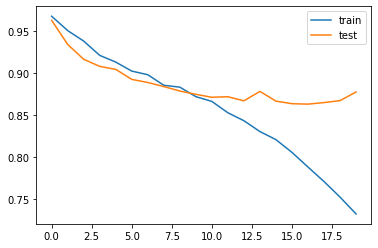

In [73]:
# plot training history
pyplot.plot(h4.history['loss'], label='train')
pyplot.plot(h4.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [74]:
m4.save("../models/conv1d_loss-sgd_batch-16_epochs-20.h5")